In [10]:
from pysheds.grid import Grid

grid = Grid.from_raster(r'data-inputs\\USGS.tif')
dem = grid.read_raster(r'data-inputs\\USGS.tif')

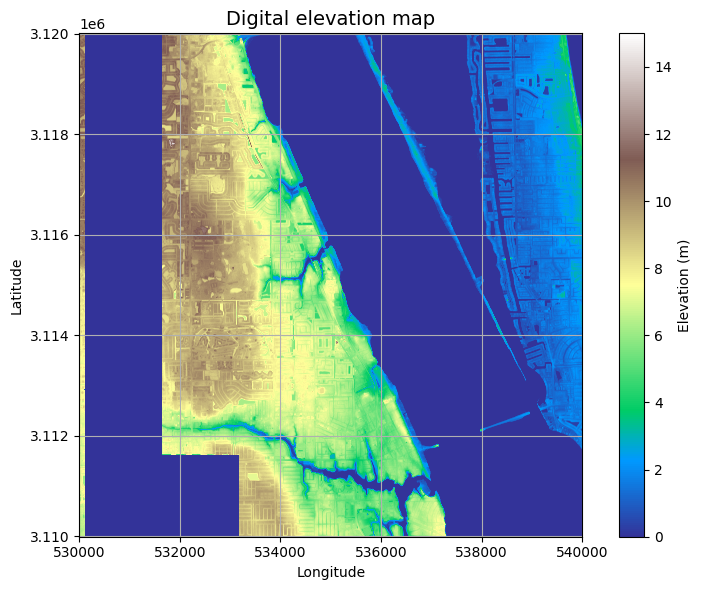

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Define the normalization for the elevation between 0 and 15 meters
norm = colors.Normalize(vmin=0, vmax=15)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

# Plot the DEM with normalization applied
plt.imshow(dem, extent=grid.extent, cmap='terrain', norm=norm, zorder=1)
#plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [236]:

pit_filled_dem = grid.fill_pits(dem)

flooded_dem = grid.fill_depressions(pit_filled_dem)
    

inflated_dem = grid.resolve_flats(flooded_dem)

dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    

fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

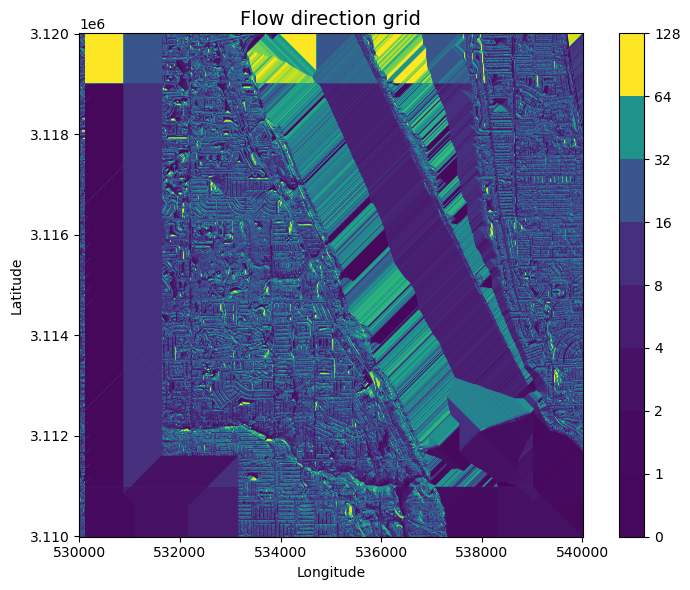

In [237]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

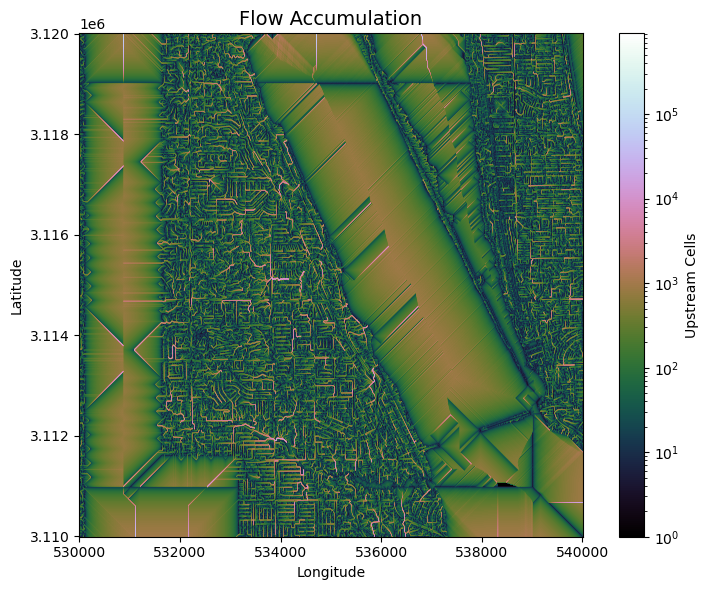

In [238]:

acc = grid.accumulation(fdir, dirmap=dirmap)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

Text(0.5, 1.0, 'Delineated Catchment')

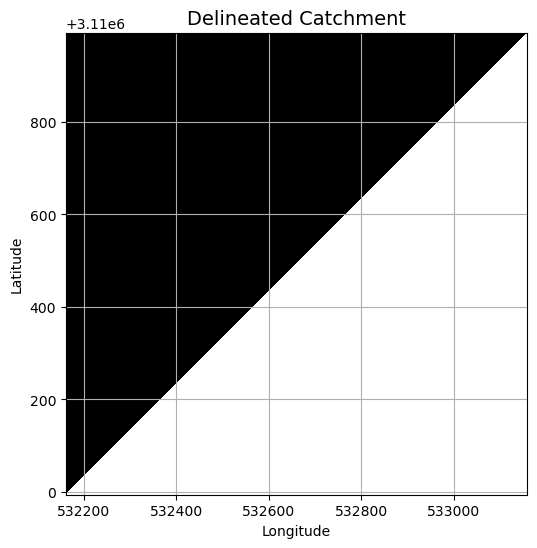

In [239]:

x, y = 534750, 3.114

#x, y = 534000, 3.117


x_snap, y_snap = grid.snap_to_mask(acc > 250000, (x, y))

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')


grid.clip_to(catch)
clipped_catch = grid.view(catch)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

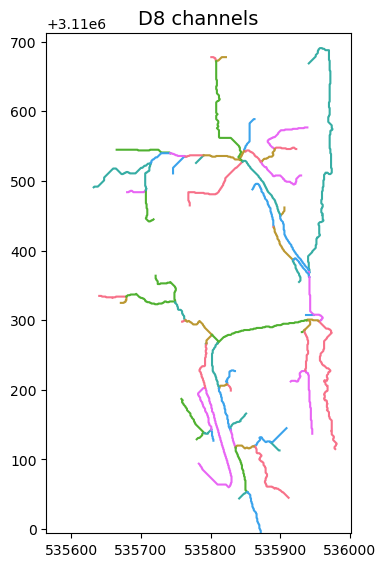

In [183]:

branches = grid.extract_river_network(fdir, acc > 1000, dirmap=dirmap)

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [184]:
from collections import defaultdict
import numpy as np


node_counts = defaultdict(int)

precision = 10


for branch in branches['features']:
    
    line = np.asarray(branch['geometry']['coordinates'])
    
    
    for point in line:
       
        rounded_point = tuple(np.round(point, precision))
        node_counts[rounded_point] += 1

junctions = [node for node, count in node_counts.items() if count > 1]

print(f"Junction points: {junctions}")

Junction points: [(535807.999962, 3110672.000046), (535841.999962, 3110532.000046), (535941.999962, 3110369.000046), (535847.999962, 3110543.000046), (535891.999962, 3110546.000046), (535871.999962, 3110528.000046), (535741.999962, 3110540.000046), (535789.999962, 3110537.000046), (535763.999962, 3110535.000046), (535843.999962, 3110530.000046), (535713.999962, 3110526.000046), (535890.999962, 3110433.000046), (535706.999962, 3110487.000046), (535845.999962, 3110528.000046), (535899.999962, 3110450.000046), (535941.999962, 3110362.000046), (535918.999962, 3110387.000046), (535748.999962, 3110326.000046), (535947.999962, 3110308.000046), (535678.999962, 3110334.000046), (535763.999962, 3110300.000046), (535954.999962, 3110299.000046), (535801.999962, 3110279.000046), (535934.999962, 3110286.000046), (535793.999962, 3110267.000046), (535822.999962, 3110208.000046), (535935.999962, 3110228.000046), (535811.999962, 3110202.000046), (535790.999962, 3110138.000046), (535828.999962, 3110142.0

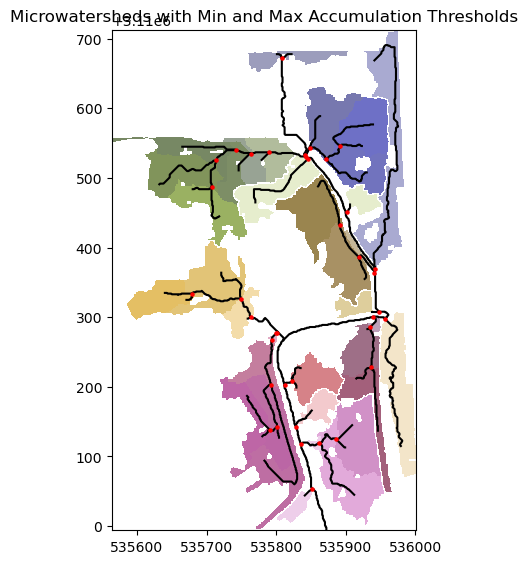

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a figure for plotting all catchments
plt.figure(figsize=(8.5, 6.5))

# Set the plot boundaries and aspect ratio
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
plt.gca().set_aspect('equal')

# Define colormap for unique catchment colors
colors = plt.cm.get_cmap('tab20b', len(junctions))

# Define the minimum and maximum accumulation thresholds
min_acc = 1000
max_acc = 20000

# Loop over each junction and plot its catchment
for i, junction in enumerate(junctions):
    x, y = junction
    
    # Snap the junction to the nearest cell where accumulation is between min_acc and max_acc
    mask = (acc > min_acc) & (acc < max_acc)
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    
    # Delineate the catchment for the snapped point
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    
    # Plot the catchment with a unique color
    plt.imshow(np.where(catch, catch, np.nan), extent=grid.extent, cmap=mcolors.ListedColormap([colors(i)]), alpha=0.5)

# Plot the river network on top of the catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
for junction in junctions:
    x, y = junction
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    plt.scatter(x_snap, y_snap, color='red', s=5, zorder=5)

# Add title and show the combined plot
plt.title('Microwatersheds with Min and Max Accumulation Thresholds')
plt.show()


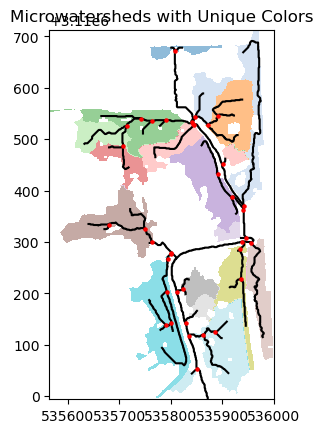

In [218]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Set the plot boundaries and aspect ratio
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
plt.gca().set_aspect('equal')

# Define colormap for unique catchment colors
colors = plt.cm.get_cmap('tab20', len(junctions))  # Use a colormap that supports many discrete colors

# Define the minimum and maximum accumulation thresholds
min_acc = 1000
max_acc = 20000

# Create an empty array to store the combined catchment mask
# Use integers to assign a different number for each catchment
combined_catchment = np.zeros(grid.shape, dtype=int)

# Loop over each junction and plot its catchment with a unique color
for i, junction in enumerate(junctions):
    x, y = junction
    
    # Snap the junction to the nearest cell where accumulation is between min_acc and max_acc
    mask = (acc > min_acc) & (acc < max_acc)
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    
    # Delineate the catchment for the snapped point
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    
    # Assign a unique integer value for each catchment
    combined_catchment[catch] = i + 1  # Start numbering catchments from 1
    
# Plot the combined catchments with a unique color for each
# Use a discrete colormap
plt.imshow(np.where(combined_catchment > 0, combined_catchment, np.nan), extent=grid.extent, cmap=colors, alpha=0.5)

# Plot the river network on top of the combined catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
for junction in junctions:
    x, y = junction
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    plt.scatter(x_snap, y_snap, color='red', s=5, zorder=5)

# Add title and show the combined plot
plt.title('Microwatersheds with Unique Colors')
plt.show()
